In [1]:
from IPython.display import clear_output
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, train
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

subject_id = 5

eeg_data_1 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv(f'data/subject{subject_id}/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv(f'data/subject{subject_id}/gradcpt-session1-3.csv')

# Channels
channels = ['AF7', 'AF8', 'TP9', 'TP10'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

In [2]:
# Sync trial start and end times

eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

# Concatenate the trials
eeg_data = pd.concat([
    eeg_data_1, 
    eeg_data_2, 
    #eeg_data_3
], ignore_index=True)
gradcpt_data = pd.concat([
    gradcpt_data_1, 
    gradcpt_data_2, 
    #gradcpt_data_3
], ignore_index=True)

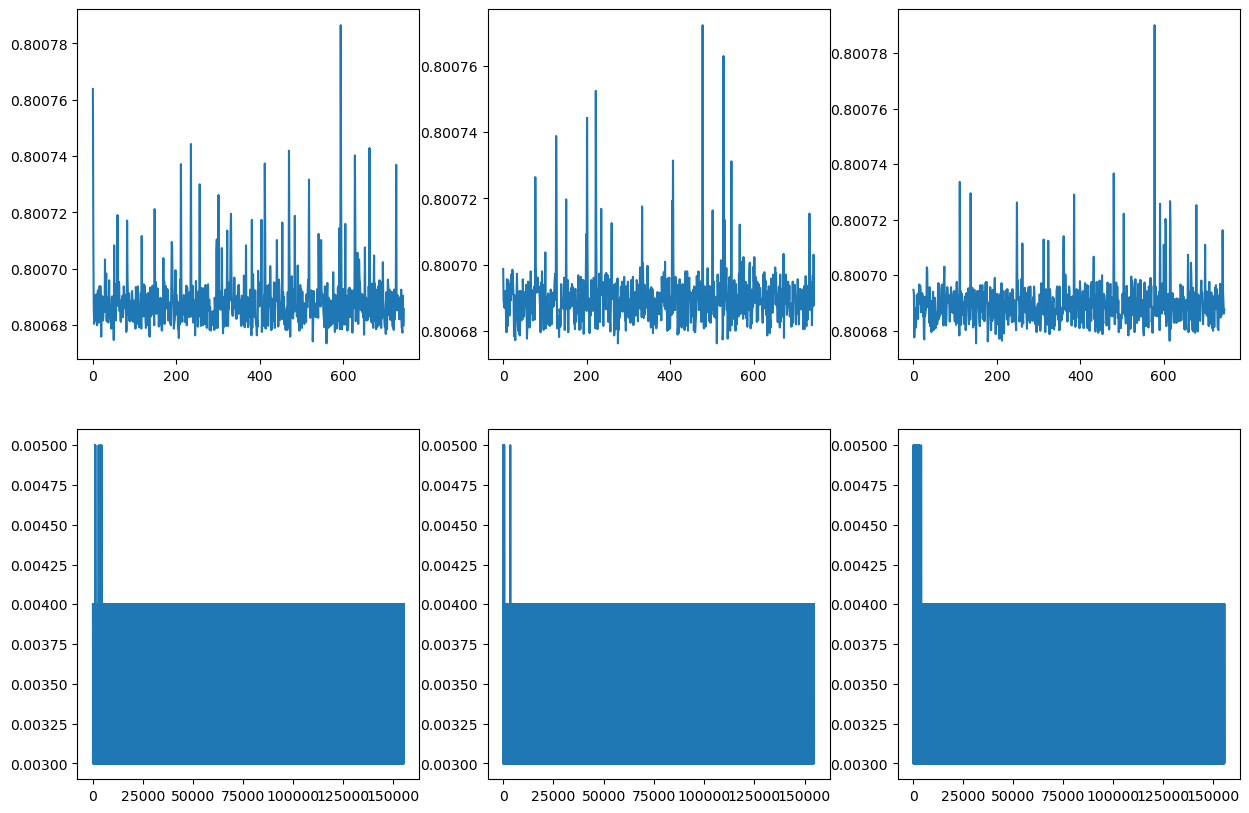

In [3]:
eeg_trials = [eeg_data_1, eeg_data_2, eeg_data_3]
gradcpt_trials = [gradcpt_data_1, gradcpt_data_2, gradcpt_data_3]
plot_sample_durations(eeg_trials, gradcpt_trials)

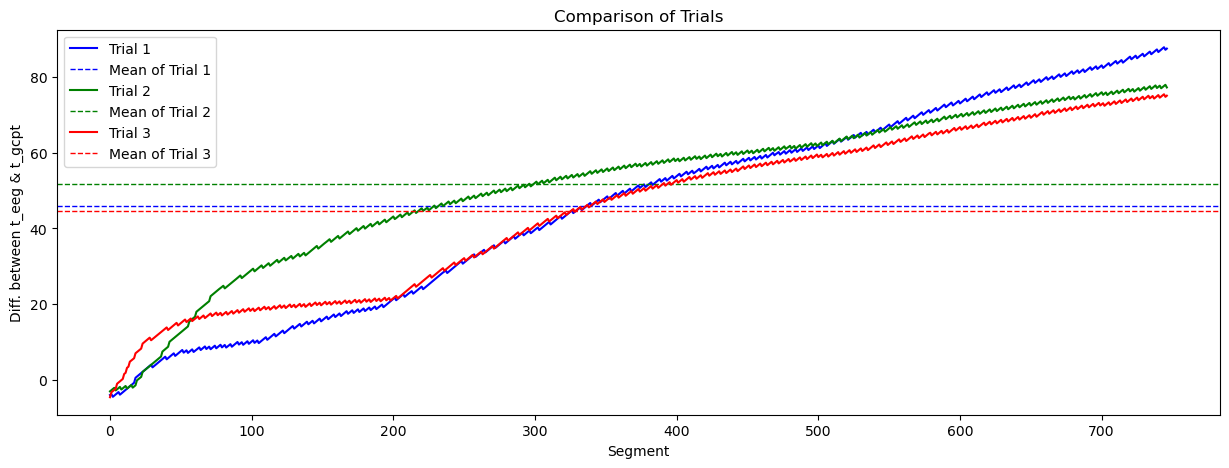

In [4]:
plot_eeg_gradcpt_time_diff(eeg_trials, gradcpt_trials)

### z-normalization

In [5]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Artificat removal

In [6]:
from scipy.signal import iirnotch, filtfilt
for channel in channels:
    fs = 256
    f0 = 50
    quality_factor = 30
    
    b, a = iirnotch(f0, quality_factor, fs)
    eeg_data.loc[:, f'{channel}_filt'] = filtfilt(b, a, eeg_data[f'{channel}_normal'])
    eeg_data[f'{channel}_artif_removed'] = remove_artifacts_from_column(eeg_data[f'{channel}_filt']) 

### Bandpass filtering

In [7]:
from scipy.signal import butter
for channel in channels:
    lowcut = 0.5
    highcut = 50.0
    fs = 256  
    filter_order = 5
    
    # Butterworth filter
    nyquist_freq = 0.5 * fs
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    eeg_data.loc[:, [f'{channel}_bandpassed']] = filtfilt(b, a, eeg_data[f'{channel}_artif_removed'])

### Normalization

In [8]:
for channel in channels:
    eeg_data[f'{channel}_normal'] = z_normalize_column(eeg_data[channel])

### Separate trials

In [9]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = eeg_data[eeg_data['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = eeg_data[eeg_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = eeg_data[eeg_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Extract features

In [10]:
# Initialize empty DataFrames for each trial
features_t1 = pd.DataFrame()
features_t2 = pd.DataFrame()
features_t3 = pd.DataFrame()

for trial in [1, 2, 3]:
    # Select the current trial data
    if trial == 1:
        cur_eeg_df = eeg_data_t1
        cur_gcpt_df = gradcpt_data_t1
    elif trial == 2:
        cur_eeg_df = eeg_data_t2
        cur_gcpt_df = gradcpt_data_t2
    else:
        cur_eeg_df = eeg_data_t3
        cur_gcpt_df = gradcpt_data_t3
    
    # Process each channel
    for i, channel in enumerate(channels):
        # Segment the current EEG data
        segments = segment_column(cur_eeg_df[f'{channel}_bandpassed'], cur_gcpt_df)
        # Decompose each segment
        segment_bands = [decompose_segment(segment) for segment in segments]
        # Extract features from the decomposed segments
        features = extract_features(channel, segment_bands)
        
        # Append the features to the respective DataFrame
        if trial == 1:
            features_t1 = pd.concat([features_t1, features], axis=1)
        elif trial == 2:
            features_t2 = pd.concat([features_t2, features], axis=1)
        else:
            features_t3 = pd.concat([features_t3, features], axis=1)
        
        clear_output(wait=True)
        print(f'{(trial-1)*len(channels)+i+1}/{3*len(channels)} Done')

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

12/12 Done


In [11]:
combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

In [12]:
af7_df = combined_features_df.iloc[:, list(range(0, 250)) + [-1]].copy()
af8_df = combined_features_df.iloc[:, list(range(250, 500)) + [-1]].copy()
tp9_df = combined_features_df.iloc[:, list(range(500, 750)) + [-1]].copy()
tp10_df = combined_features_df.iloc[:, list(range(750, combined_features_df.shape[1]-1)) + [-1]].copy()

In [13]:
features_range = list(range(10, 260, 10))
channels = ['AF7', 'AF8', 'TP9', 'TP10', 'Combined']
metrics = ['train_acc', 'test_acc', 'f1_score']

data = []

subject_data = {
    subject_id: {'AF7': af7_df, 'AF8': af8_df, 'TP9': tp9_df, 'TP10': tp10_df, 'Combined': combined_features_df},
}

for subject, datasets in subject_data.items():
    for feats in features_range:
        print(f'{feats/10}/25 in progress')
        for channel, df in datasets.items():
            metrics_result = train(runs=2, num_features=feats, df=df)
            for metric in metrics:
                data.append({
                    'Subject': subject,
                    'Channel': channel,
                    'Num_Features': feats,
                    'Metric': metric,
                    'Value': metrics_result.get(metric)
                })

results_df = pd.DataFrame(data)

results_df.to_csv(f'subject_{subject_id}_results.csv', index=False)

1.0/25 in progress
2.0/25 in progress
3.0/25 in progress
4.0/25 in progress
5.0/25 in progress
6.0/25 in progress
7.0/25 in progress
8.0/25 in progress
9.0/25 in progress
10.0/25 in progress
11.0/25 in progress
12.0/25 in progress
13.0/25 in progress
14.0/25 in progress
15.0/25 in progress
16.0/25 in progress
17.0/25 in progress
18.0/25 in progress
19.0/25 in progress
20.0/25 in progress
21.0/25 in progress
22.0/25 in progress
23.0/25 in progress
24.0/25 in progress
25.0/25 in progress
